<a href="https://colab.research.google.com/github/Lucs1590/strava-analysis/blob/main/strava_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Strava Analysis
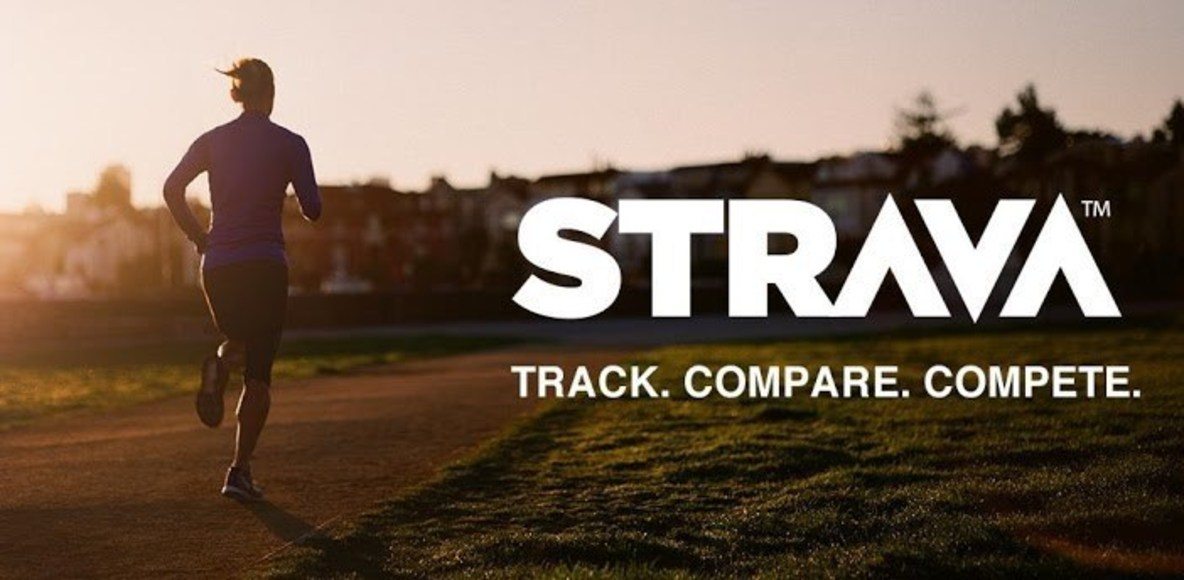
This notebook aims to do a data exploration looking for a pattern in the user data and then try to predict a certain pace based on the user data.

# Imports

In [1]:
# general
import subprocess
import calendar
from geopy.geocoders import Nominatim

# df and plotting
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# machine learning
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

# Getting data and first contact

In [2]:
pd.set_option('display.max_columns', None)
%matplotlib widget
%matplotlib inline

In [3]:
# subprocess.call(['python3', 'get_activities.py'])

In [4]:
df = pd.read_csv('result/strava_all_activities.csv')

In [5]:
df.head()

,Unnamed: 0,Unnamed: 0.1,resource_state,name,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,start_date_local,timezone,utc_offset,location_city,location_state,location_country,achievement_count,kudos_count,comment_count,athlete_count,photo_count,trainer,commute,manual,private,visibility,flagged,gear_id,start_latlng,end_latlng,average_speed,max_speed,has_heartrate,average_heartrate,max_heartrate,heartrate_opt_out,display_hide_heartrate_option,upload_id,upload_id_str,external_id,from_accepted_tag,pr_count,total_photo_count,has_kudoed,athlete.id,athlete.resource_state,map.id,map.summary_polyline,map.resource_state,workout_type,average_cadence,elev_high,elev_low,average_watts,kilojoules,device_watts
0,0,0,2,Natação matinal,300.0,427,427,0.0,Swim,Swim,8096287021,2022-11-10T10:08:56Z,2022-11-10T07:08:56Z,(GMT-03:00) America/Sao_Paulo,-10800.0,NaN,NaN,Brasil,0,3,0,1,0,True,False,False,False,everyone,False,NaN,[],[],0.703,5.000,True,116.9,142.0,False,True,8.667617e+09,8.667617e+09,shealth04fce1a7-9bac-4129-b470-c81ae9113da3.tcx,False,0,0,False,47005114,1,a8096287021,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2,Corrida ao entardecer,5071.0,1413,1426,24.9,Run,Run,8084194066,2022-11-07T21:05:35Z,2022-11-07T18:05:35Z,(GMT-03:00) America/Sao_Paulo,-10800.0,NaN,NaN,Brasil,4,4,0,1,0,False,False,False,False,everyone,False,g7550415,"[-22.103855, -50.178402]","[-22.10412, -50.17807]",3.589,10.477,True,169.5,181.0,False,True,8.654095e+09,8.654095e+09,shealth3ba16bdd-183c-4b25-a87d-999801445736.tcx,False,2,0,False,47005114,1,a8084194066,bd|eC`ngqHFYJMFCHBDCDKFW?OHKFk@DOJKBi@FUJOD?DG...,2,NaN,83.0,597.1,587.8,NaN,NaN,NaN
2,2,2,2,Caminhada ao entardecer,5.0,5,253,0.0,Walk,Walk,8084192044,2022-11-07T21:00:42Z,2022-11-07T18:00:42Z,(GMT-03:00) America/Sao_Paulo,-10800.0,NaN,NaN,Brasil,0,3,0,1,0,False,False,False,False,everyone,False,g7550415,"[-22.103764, -50.17861]","[-22.103783, -50.178566]",1.001,1.001,True,121.0,130.0,False,True,8.654093e+09,8.654093e+09,shealthfc6f67fd-eba8-41bc-88f1-1b3d0c3368f6.tcx,False,0,0,False,47005114,1,a8084192044,pc|eChogqHBG,2,NaN,119.0,596.6,596.6,NaN,NaN,NaN
3,3,3,2,Corrida ao entardecer,3811.4,1129,1210,16.9,Run,Run,8055100801,2022-11-01T22:25:02Z,2022-11-01T19:25:02Z,(GMT-03:00) America/Sao_Paulo,-10800.0,NaN,NaN,Brasil,0,2,0,2,0,False,False,False,False,everyone,False,g7550415,"[-22.103725, -50.178867]","[-22.104502, -50.177254]",3.376,5.069,True,168.3,182.0,False,True,8.621085e+09,8.621085e+09,shealtha7303d83-9ae2-4f1e-99c3-3526cdeaf434.tcx,False,0,0,False,47005114,1,a8055100801,hc|eC|pgqHGDy@fBG^[dAMn@c@fDUpCAh@In@CfASbBWrC...,2,NaN,82.1,607.3,593.6,NaN,NaN,NaN
4,4,4,2,Caminhada ao entardecer,460.3,303,303,0.0,Walk,Walk,8033899756,2022-10-28T21:39:37Z,2022-10-28T18:39:37Z,(GMT-03:00) America/Sao_Paulo,-10800.0,NaN,NaN,Brasil,0,5,0,1,0,False,False,False,False,everyone,False,g7550415,"[-22.103758, -50.178432]","[-22.101254, -50.180313]",1.519,2.482,True,134.3,141.0,False,True,8.596854e+09,8.596854e+09,shealth0fbf1070-92cf-4038-9851-3a96e1711bf3.tcx,False,0,0,False,47005114,1,a8033899756,nc|eCfngqHFJI?CHQAMGM?OGKHC`@Mb@?Zi@\IJGNCXAj@...,2,NaN,115.5,598.6,585.9,NaN,NaN,NaN


In [6]:
df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'resource_state', 'name', 'distance',
       'moving_time', 'elapsed_time', 'total_elevation_gain', 'type',
       'sport_type', 'id', 'start_date', 'start_date_local', 'timezone',
       'utc_offset', 'location_city', 'location_state', 'location_country',
       'achievement_count', 'kudos_count', 'comment_count', 'athlete_count',
       'photo_count', 'trainer', 'commute', 'manual', 'private', 'visibility',
       'flagged', 'gear_id', 'start_latlng', 'end_latlng', 'average_speed',
       'max_speed', 'has_heartrate', 'average_heartrate', 'max_heartrate',
       'heartrate_opt_out', 'display_hide_heartrate_option', 'upload_id',
       'upload_id_str', 'external_id', 'from_accepted_tag', 'pr_count',
       'total_photo_count', 'has_kudoed', 'athlete.id',
       'athlete.resource_state', 'map.id', 'map.summary_polyline',
       'map.resource_state', 'workout_type', 'average_cadence', 'elev_high',
       'elev_low', 'average_watts', 'kilojoules', 'de

In [7]:
df.shape

(265, 58)

In [8]:
df.isnull().sum().sum()

2234

In [9]:
null_df = [[col, df[col].isnull().sum()] for col in df.columns]
list(filter(lambda x: x[1]>0, null_df))

[['location_city', 265],
 ['location_state', 265],
 ['gear_id', 87],
 ['average_heartrate', 167],
 ['max_heartrate', 167],
 ['upload_id', 42],
 ['upload_id_str', 42],
 ['external_id', 90],
 ['map.summary_polyline', 50],
 ['workout_type', 130],
 ['average_cadence', 99],
 ['elev_high', 47],
 ['elev_low', 47],
 ['average_watts', 246],
 ['kilojoules', 246],
 ['device_watts', 244]]

## Data Cleaning

In [10]:
raw_df = df

In [11]:
selected_columns = ['distance', 'moving_time', 'elapsed_time',
                    'total_elevation_gain', 'type','sport_type', 'id', 'start_date',
                    'start_date_local','location_country', 'achievement_count', 'kudos_count',
                    'comment_count','athlete_count', 'start_latlng',
                    'end_latlng', 'average_speed', 'max_speed', 'average_cadence',
                    'average_heartrate', 'max_heartrate', 'elev_high','elev_low',
                    'upload_id', 'external_id', 'pr_count', 'map.summary_polyline']

In [12]:
df = df[selected_columns]
df.head()

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,start_date_local,location_country,achievement_count,kudos_count,comment_count,athlete_count,start_latlng,end_latlng,average_speed,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,elev_low,upload_id,external_id,pr_count,map.summary_polyline
0,300.0,427,427,0.0,Swim,Swim,8096287021,2022-11-10T10:08:56Z,2022-11-10T07:08:56Z,Brasil,0,3,0,1,[],[],0.703,5.000,NaN,116.9,142.0,NaN,NaN,8.667617e+09,shealth04fce1a7-9bac-4129-b470-c81ae9113da3.tcx,0,NaN
1,5071.0,1413,1426,24.9,Run,Run,8084194066,2022-11-07T21:05:35Z,2022-11-07T18:05:35Z,Brasil,4,4,0,1,"[-22.103855, -50.178402]","[-22.10412, -50.17807]",3.589,10.477,83.0,169.5,181.0,597.1,587.8,8.654095e+09,shealth3ba16bdd-183c-4b25-a87d-999801445736.tcx,2,bd|eC`ngqHFYJMFCHBDCDKFW?OHKFk@DOJKBi@FUJOD?DG...
2,5.0,5,253,0.0,Walk,Walk,8084192044,2022-11-07T21:00:42Z,2022-11-07T18:00:42Z,Brasil,0,3,0,1,"[-22.103764, -50.17861]","[-22.103783, -50.178566]",1.001,1.001,119.0,121.0,130.0,596.6,596.6,8.654093e+09,shealthfc6f67fd-eba8-41bc-88f1-1b3d0c3368f6.tcx,0,pc|eChogqHBG
3,3811.4,1129,1210,16.9,Run,Run,8055100801,2022-11-01T22:25:02Z,2022-11-01T19:25:02Z,Brasil,0,2,0,2,"[-22.103725, -50.178867]","[-22.104502, -50.177254]",3.376,5.069,82.1,168.3,182.0,607.3,593.6,8.621085e+09,shealtha7303d83-9ae2-4f1e-99c3-3526cdeaf434.tcx,0,hc|eC|pgqHGDy@fBG^[dAMn@c@fDUpCAh@In@CfASbBWrC...
4,460.3,303,303,0.0,Walk,Walk,8033899756,2022-10-28T21:39:37Z,2022-10-28T18:39:37Z,Brasil,0,5,0,1,"[-22.103758, -50.178432]","[-22.101254, -50.180313]",1.519,2.482,115.5,134.3,141.0,598.6,585.9,8.596854e+09,shealth0fbf1070-92cf-4038-9851-3a96e1711bf3.tcx,0,nc|eCfngqHFJI?CHQAMGM?OGKHC`@Mb@?Zi@\IJGNCXAj@...


In [13]:
df['start_date_local'] = pd.to_datetime(df['start_date_local'], errors='coerce')

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_8232/4095640816.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['start_date_local'] = pd.to_datetime(df['start_date_local'], errors='coerce')


In [14]:
df = df.sort_values(by='start_date_local')

In [15]:
df['weekday'] = df['start_date_local'].map(lambda x: x.weekday)
df['start_time'] = df['start_date_local'].dt.time
df['start_time'] = df['start_time'].astype(str)
df['start_date'] = df['start_date_local'].dt.date

In [16]:
df = df.drop('start_date_local', 1)
df.head()

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_8232/2372681409.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('start_date_local', 1)


,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,kudos_count,comment_count,athlete_count,start_latlng,end_latlng,average_speed,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,elev_low,upload_id,external_id,pr_count,map.summary_polyline,weekday,start_time
264,1585.6,345,345,10.3,Ride,Ride,2753119647,2019-09-30,Brasil,0,0,0,1,"[-22.070302, -50.293182]","[-22.07021, -50.306393]",4.596,8.9,NaN,NaN,NaN,606.2,596.4,2.917847e+09,NaN,0,``ueCpo_rHEBd@jAt@z@bBbCrBbDTn@?HDHR^^z@h@~ApA...,0,20:09:18
263,1556.1,477,1531,26.0,Run,Run,2753195842,2019-09-30,Brasil,0,0,0,1,"[-22.067056, -50.307344]","[-22.069929, -50.306762]",3.262,3.6,NaN,NaN,NaN,602.6,589.4,2.917926e+09,NaN,0,b~teC|s`rHhAxD`BrD@HRr@Vv@R`@gEaMEJDB?HLd@Vv@b...,0,20:33:06
262,225.4,61,61,0.0,Ride,Ride,2753233770,2019-09-30,Brasil,0,0,0,1,"[-22.069931, -50.306663]","[-22.069633, -50.304896]",3.695,7.1,NaN,NaN,NaN,607.3,599.1,2.917969e+09,NaN,0,bpueCto`rHP@BGf@QBG?MKs@[iAuAuD,0,21:15:01
261,203.7,62,62,0.0,Ride,Ride,2755746533,2019-10-01,Brasil,0,0,0,1,[],[],3.285,7.7,NaN,NaN,NaN,599.0,596.8,2.920597e+09,NaN,0,NaN,1,20:08:30
260,192.9,61,61,0.0,Ride,Ride,2755853084,2019-10-01,Brasil,0,0,0,1,"[-22.069822, -50.306695]","[-22.069754, -50.305242]",3.162,6.2,NaN,NaN,NaN,607.1,599.2,2.920706e+09,NaN,0,loueCzo`rHNDH?f@WDE@GG}@S}@{@eC,1,21:02:29


In [17]:
df = df.drop(df[(df.distance < 1) & (df.type == 'Run')].index)

In [18]:
df = df.drop(df[(df.distance < 1) & (df.type == 'Ride')].index)

In [19]:
df = df.drop(df[df.average_speed > 30].index)

In [20]:
df = df.reset_index(drop=True)

In [21]:
geolocator = Nominatim(user_agent="strava_exploration_data")

In [22]:
def get_city_state_from_value(value):
    value = value.replace('[','').replace(']','').split(',')
    if value != ['']:
        location = geolocator.reverse(', '.join(value))
        result = f'{location[0].split(",")[1]}, {location[0].split(",")[4]}'
    else:
        result = 'unknown'
    return result

In [23]:
df['location'] = df['start_latlng'].map(get_city_state_from_value)

In [24]:
df['elev_high'] = df['elev_high'].fillna(value=0)
df['elev_low'] = df['elev_low'].fillna(value=0)
df['upload_id'] = df['upload_id'].fillna(value='unknown')
df['external_id'] = df['external_id'].fillna(value='unknown')
df['map.summary_polyline'] = df['map.summary_polyline'].fillna(value='unknown')

In [25]:
df['average_cadence'] = df['average_cadence'].fillna(value=df['average_cadence'].mean())
df['average_heartrate'] = df['average_heartrate'].fillna(value=df['average_heartrate'].mean())
df['max_heartrate'] = df['max_heartrate'].fillna(value=df['max_heartrate'].mean())

In [26]:
df['moving_time_minutes'] = round(df['moving_time']/60, 2)
df['distance_km'] = round(df['distance'] / 1000, 2)
df['pace'] = df['moving_time_minutes'] / df['distance_km']
df['avg_speed_kmh'] = round(60/df['pace'], 2)
df['max_speed_kmh'] = round(df['max_speed']*3.6, 2)
df['elev'] = df['elev_high'] - df['elev_low']
df['year']= df['start_date'].map(lambda x: x.year)
df

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,kudos_count,comment_count,athlete_count,start_latlng,end_latlng,average_speed,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,elev_low,upload_id,external_id,pr_count,map.summary_polyline,weekday,start_time,location,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev
0,1585.6,345,345,10.3,Ride,Ride,2753119647,2019-09-30,Brasil,0,0,0,1,"[-22.070302, -50.293182]","[-22.07021, -50.306393]",4.596,8.900,78.644578,158.039796,174.489796,606.2,596.4,2917847272.0,unknown,0,``ueCpo_rHEBd@jAt@z@bBbCrBbDTn@?HDHR^^z@h@~ApA...,0,20:09:18,"Quintana, São Paulo",5.75,1.59,3.616352,16.59,32.04,9.8
1,1556.1,477,1531,26.0,Run,Run,2753195842,2019-09-30,Brasil,0,0,0,1,"[-22.067056, -50.307344]","[-22.069929, -50.306762]",3.262,3.600,78.644578,158.039796,174.489796,602.6,589.4,2917925990.0,unknown,0,b~teC|s`rHhAxD`BrD@HRr@Vv@R`@gEaMEJDB?HLd@Vv@b...,0,20:33:06,"Rua Expedicionários, Região Imediata de Marília",7.95,1.56,5.096154,11.77,12.96,13.2
2,225.4,61,61,0.0,Ride,Ride,2753233770,2019-09-30,Brasil,0,0,0,1,"[-22.069931, -50.306663]","[-22.069633, -50.304896]",3.695,7.100,78.644578,158.039796,174.489796,607.3,599.1,2917969006.0,unknown,0,bpueCto`rHP@BGf@QBG?MKs@[iAuAuD,0,21:15:01,"BAIRRO SANTA MERCEDES, Região Geográfica Int...",1.02,0.23,4.434783,13.53,25.56,8.2
3,203.7,62,62,0.0,Ride,Ride,2755746533,2019-10-01,Brasil,0,0,0,1,[],[],3.285,7.700,78.644578,158.039796,174.489796,599.0,596.8,2920596814.0,unknown,0,unknown,1,20:08:30,unknown,1.03,0.20,5.150000,11.65,27.72,2.2
4,192.9,61,61,0.0,Ride,Ride,2755853084,2019-10-01,Brasil,0,0,0,1,"[-22.069822, -50.306695]","[-22.069754, -50.305242]",3.162,6.200,78.644578,158.039796,174.489796,607.1,599.2,2920706057.0,unknown,0,loueCzo`rHNDH?f@WDE@GG}@S}@{@eC,1,21:02:29,"BAIRRO SANTA MERCEDES, Região Geográfica Int...",1.02,0.19,5.368421,11.18,22.32,7.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,460.3,303,303,0.0,Walk,Walk,8033899756,2022-10-28,Brasil,0,5,0,1,"[-22.103758, -50.178432]","[-22.101254, -50.180313]",1.519,2.482,115.500000,134.300000,141.000000,598.6,585.9,8596854388.0,shealth0fbf1070-92cf-4038-9851-3a96e1711bf3.tcx,0,nc|eCfngqHFJI?CHQAMGM?OGKHC`@Mb@?Zi@\IJGNCXAj@...,4,18:39:37,"Pompeia, São Paulo",5.05,0.46,10.978261,5.47,8.94,12.7
260,3811.4,1129,1210,16.9,Run,Run,8055100801,2022-11-01,Brasil,0,2,0,2,"[-22.103725, -50.178867]","[-22.104502, -50.177254]",3.376,5.069,82.100000,168.300000,182.000000,607.3,593.6,8621084759.0,shealtha7303d83-9ae2-4f1e-99c3-3526cdeaf434.tcx,0,hc|eC|pgqHGDy@fBG^[dAMn@c@fDUpCAh@In@CfASbBWrC...,1,19:25:02,"Pompeia, São Paulo",18.82,3.81,4.939633,12.15,18.25,13.7
261,5.0,5,253,0.0,Walk,Walk,8084192044,2022-11-07,Brasil,0,3,0,1,"[-22.103764, -50.17861]","[-22.103783, -50.178566]",1.001,1.001,119.000000,121.000000,130.000000,596.6,596.6,8654093177.0,shealthfc6f67fd-eba8-41bc-88f1-1b3d0c3368f6.tcx,0,pc|eChogqHBG,0,18:00:42,"Pompeia, São Paulo",0.08,0.00,inf,0.00,3.60,0.0
262,5071.0,1413,1426,24.9,Run,Run,8084194066,2022-11-07,Brasil,4,4,0,1,"[-22.103855, -50.178402]","[-22.10412, -50.17807]",3.589,10.477,83.000000,169.500000,181.000000,597.1,587.8,8654095397.0,shealth3ba16bdd-183c-4b25-a87d-999801445736.tcx,2,bd|eC`ngqHFYJMFCHBDCDKFW?OHKFk@DOJKBi@FUJOD?DG...,0,18:05:35,"Pompeia, São Paulo",23.55,5.07,4.644970,12.92,37.72,9.3


In [27]:
df['pace_sub_5'] = np.where(df['pace']<=5, True, False)
df

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,kudos_count,comment_count,athlete_count,start_latlng,end_latlng,average_speed,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,elev_low,upload_id,external_id,pr_count,map.summary_polyline,weekday,start_time,location,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,pace_sub_5
0,1585.6,345,345,10.3,Ride,Ride,2753119647,2019-09-30,Brasil,0,0,0,1,"[-22.070302, -50.293182]","[-22.07021, -50.306393]",4.596,8.900,78.644578,158.039796,174.489796,606.2,596.4,2917847272.0,unknown,0,``ueCpo_rHEBd@jAt@z@bBbCrBbDTn@?HDHR^^z@h@~ApA...,0,20:09:18,"Quintana, São Paulo",5.75,1.59,3.616352,16.59,32.04,9.8,True
1,1556.1,477,1531,26.0,Run,Run,2753195842,2019-09-30,Brasil,0,0,0,1,"[-22.067056, -50.307344]","[-22.069929, -50.306762]",3.262,3.600,78.644578,158.039796,174.489796,602.6,589.4,2917925990.0,unknown,0,b~teC|s`rHhAxD`BrD@HRr@Vv@R`@gEaMEJDB?HLd@Vv@b...,0,20:33:06,"Rua Expedicionários, Região Imediata de Marília",7.95,1.56,5.096154,11.77,12.96,13.2,False
2,225.4,61,61,0.0,Ride,Ride,2753233770,2019-09-30,Brasil,0,0,0,1,"[-22.069931, -50.306663]","[-22.069633, -50.304896]",3.695,7.100,78.644578,158.039796,174.489796,607.3,599.1,2917969006.0,unknown,0,bpueCto`rHP@BGf@QBG?MKs@[iAuAuD,0,21:15:01,"BAIRRO SANTA MERCEDES, Região Geográfica Int...",1.02,0.23,4.434783,13.53,25.56,8.2,True
3,203.7,62,62,0.0,Ride,Ride,2755746533,2019-10-01,Brasil,0,0,0,1,[],[],3.285,7.700,78.644578,158.039796,174.489796,599.0,596.8,2920596814.0,unknown,0,unknown,1,20:08:30,unknown,1.03,0.20,5.150000,11.65,27.72,2.2,False
4,192.9,61,61,0.0,Ride,Ride,2755853084,2019-10-01,Brasil,0,0,0,1,"[-22.069822, -50.306695]","[-22.069754, -50.305242]",3.162,6.200,78.644578,158.039796,174.489796,607.1,599.2,2920706057.0,unknown,0,loueCzo`rHNDH?f@WDE@GG}@S}@{@eC,1,21:02:29,"BAIRRO SANTA MERCEDES, Região Geográfica Int...",1.02,0.19,5.368421,11.18,22.32,7.9,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,460.3,303,303,0.0,Walk,Walk,8033899756,2022-10-28,Brasil,0,5,0,1,"[-22.103758, -50.178432]","[-22.101254, -50.180313]",1.519,2.482,115.500000,134.300000,141.000000,598.6,585.9,8596854388.0,shealth0fbf1070-92cf-4038-9851-3a96e1711bf3.tcx,0,nc|eCfngqHFJI?CHQAMGM?OGKHC`@Mb@?Zi@\IJGNCXAj@...,4,18:39:37,"Pompeia, São Paulo",5.05,0.46,10.978261,5.47,8.94,12.7,False
260,3811.4,1129,1210,16.9,Run,Run,8055100801,2022-11-01,Brasil,0,2,0,2,"[-22.103725, -50.178867]","[-22.104502, -50.177254]",3.376,5.069,82.100000,168.300000,182.000000,607.3,593.6,8621084759.0,shealtha7303d83-9ae2-4f1e-99c3-3526cdeaf434.tcx,0,hc|eC|pgqHGDy@fBG^[dAMn@c@fDUpCAh@In@CfASbBWrC...,1,19:25:02,"Pompeia, São Paulo",18.82,3.81,4.939633,12.15,18.25,13.7,True
261,5.0,5,253,0.0,Walk,Walk,8084192044,2022-11-07,Brasil,0,3,0,1,"[-22.103764, -50.17861]","[-22.103783, -50.178566]",1.001,1.001,119.000000,121.000000,130.000000,596.6,596.6,8654093177.0,shealthfc6f67fd-eba8-41bc-88f1-1b3d0c3368f6.tcx,0,pc|eChogqHBG,0,18:00:42,"Pompeia, São Paulo",0.08,0.00,inf,0.00,3.60,0.0,False
262,5071.0,1413,1426,24.9,Run,Run,8084194066,2022-11-07,Brasil,4,4,0,1,"[-22.103855, -50.178402]","[-22.10412, -50.17807]",3.589,10.477,83.000000,169.500000,181.000000,597.1,587.8,8654095397.0,shealth3ba16bdd-183c-4b25-a87d-999801445736.tcx,2,bd|eC`ngqHFYJMFCHBDCDKFW?OHKFk@DOJKBi@FUJOD?DG...,0,18:05:35,"Pompeia, São Paulo",23.55,5.07,4.644970,12.92,37.72,9.3,True


In [28]:
null_df = [[col, df[col].isnull().sum()] for col in df.columns]
list(filter(lambda x: x[1]>0, null_df))

[]

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264 entries, 0 to 263
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   distance              264 non-null    float64
 1   moving_time           264 non-null    int64  
 2   elapsed_time          264 non-null    int64  
 3   total_elevation_gain  264 non-null    float64
 4   type                  264 non-null    object 
 5   sport_type            264 non-null    object 
 6   id                    264 non-null    int64  
 7   start_date            264 non-null    object 
 8   location_country      264 non-null    object 
 9   achievement_count     264 non-null    int64  
 10  kudos_count           264 non-null    int64  
 11  comment_count         264 non-null    int64  
 12  athlete_count         264 non-null    int64  
 13  start_latlng          264 non-null    object 
 14  end_latlng            264 non-null    object 
 15  average_speed         2

In [30]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
distance,264.0,4.950109e+03,3.283277e+03,0.000000e+00,3.051650e+03,5.017350e+03,6.096250e+03,2.290510e+04
moving_time,264.0,1.685894e+03,8.859972e+02,5.000000e+00,1.119750e+03,1.588000e+03,2.237500e+03,4.822000e+03
elapsed_time,264.0,1.731299e+03,9.000689e+02,5.800000e+01,1.197750e+03,1.602500e+03,2.285750e+03,5.340000e+03
total_elevation_gain,264.0,5.343939e+01,5.767961e+01,0.000000e+00,7.750000e+00,3.040000e+01,8.017500e+01,2.530000e+02
id,264.0,5.132083e+09,1.531382e+09,2.753120e+09,3.785331e+09,5.269671e+09,6.082037e+09,8.096287e+09
achievement_count,264.0,7.689394e-01,1.481066e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,7.000000e+00
kudos_count,264.0,3.761364e+00,2.200904e+00,0.000000e+00,2.000000e+00,4.000000e+00,5.000000e+00,1.200000e+01
comment_count,264.0,9.848485e-02,5.495916e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00
athlete_count,264.0,1.628788e+00,2.753236e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.600000e+01
average_speed,264.0,2.981799e+00,1.212274e+00,0.000000e+00,2.351250e+00,3.023500e+00,3.312500e+00,7.003000e+00


## Visualization

In [31]:
df.groupby('type')['distance'].nlargest(3)

type        
Ride     169    22905.1
         184    21513.9
         134    16910.5
Run      202    13578.7
         234    12809.8
         154    10322.7
Swim     263      300.0
Walk     48      5129.1
         181     5096.6
         49      5089.7
Workout  158        0.0
         188        0.0
         190        0.0
Name: distance, dtype: float64

In [32]:
df.groupby('type')['moving_time_minutes'].nlargest(3)

type        
Ride     169    55.50
         184    53.58
         132    49.87
Run      28     80.37
         234    73.02
         202    71.50
Swim     263     7.12
Walk     49     59.37
         181    58.58
         48     55.13
Workout  190    37.37
         188    35.08
         158    30.10
Name: moving_time_minutes, dtype: float64

In [33]:
df.groupby('weekday').mean()

,distance,moving_time,elapsed_time,total_elevation_gain,id,achievement_count,kudos_count,comment_count,athlete_count,average_speed,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,elev_low,pr_count,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,pace_sub_5
weekday,,,,,,,,,,,,,,,,,,,,,,,,
0,4085.712329,1467.643836,1517.767123,48.447945,5.442311e+09,0.465753,3.602740,0.082192,1.410959,2.893630,4.146959,80.218468,156.581535,173.412357,480.119178,468.713699,0.109589,24.460685,4.085342,NaN,10.369452,14.928767,11.405479,0.260274
1,5151.284615,1820.538462,1853.076923,56.873077,4.527129e+09,1.134615,3.634615,0.115385,1.230769,2.820385,4.829731,76.094694,158.631770,175.098116,558.942308,541.182692,0.442308,30.342115,5.151538,6.711600,10.145577,17.387115,17.759615,0.173077
2,5111.682979,1714.765957,1747.382979,55.612766,5.114048e+09,0.893617,3.680851,0.085106,1.553191,2.965936,3.915128,78.526301,155.554342,173.132002,451.602128,438.674468,0.319149,28.580213,5.111915,NaN,10.676383,14.094043,12.927660,0.212766
3,5693.676316,1747.263158,1766.500000,52.821053,5.042312e+09,1.078947,3.868421,0.078947,1.236842,3.311553,5.249553,77.962048,158.905639,174.545113,480.636842,465.634211,0.394737,29.120526,5.693158,NaN,11.918421,18.898684,15.002632,0.289474
4,3978.687500,1244.208333,1304.416667,50.320833,5.335468e+09,0.416667,3.375000,0.208333,1.416667,3.207458,4.464167,82.281526,158.774872,174.139456,555.045833,541.925000,0.166667,20.737083,3.979583,6.198176,11.555833,16.070833,13.120833,0.375000
5,6373.625000,2073.400000,2196.800000,58.620000,4.981081e+09,0.600000,4.400000,0.000000,2.550000,3.126900,4.546950,77.480060,162.748878,177.693878,481.285000,461.365000,0.150000,34.557500,6.373000,6.150716,11.253500,16.369500,19.920000,0.150000
6,6113.530000,2495.100000,2541.000000,61.280000,6.252967e+09,0.500000,5.200000,0.200000,5.800000,2.454500,4.479400,77.164458,162.815918,179.795918,556.010000,528.410000,0.100000,41.586000,6.114000,NaN,8.846000,16.126000,27.600000,0.200000


<AxesSubplot:xlabel='weekday'>

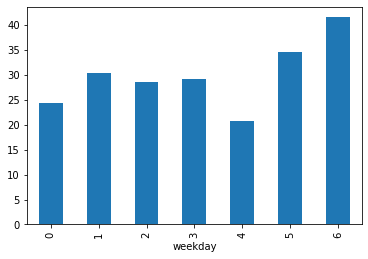

In [34]:
df.groupby('weekday').mean()['moving_time_minutes'].plot.bar()

Text(0.5, 1.0, 'Exercices')

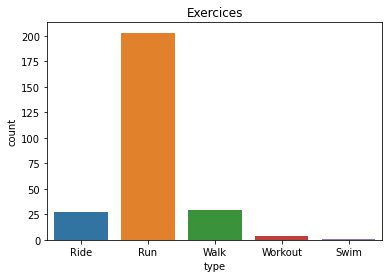

In [35]:
fig = sns.countplot(x='type', data=df).set_title('Exercices')
fig

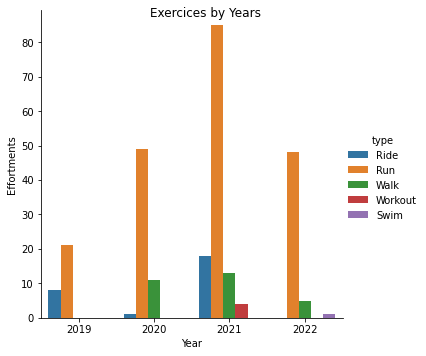

In [37]:
fig = sns.catplot(x='year', hue='type', data=df, kind='count')
fig.fig.suptitle('Exercices by Years')
fig.set_xlabels('Year')
fig.set_ylabels('Effortments')
fig

Text(0.5, 1.0, 'Average training time by day of the week')

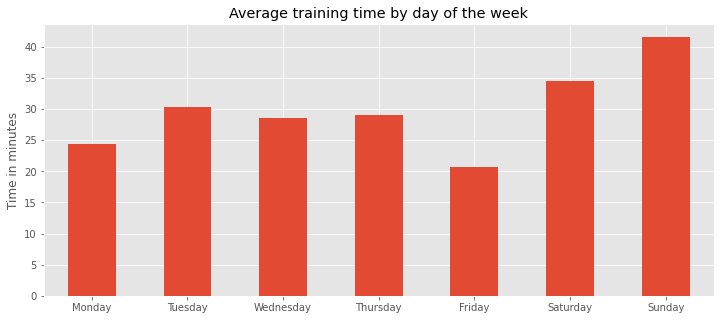

In [38]:
plt.style.use('ggplot')

df.groupby('weekday').mean()['moving_time_minutes'].plot(kind='bar', figsize=(12,5))
plt.xticks(list(range(7)), list(calendar.day_name), rotation='horizontal')
plt.xlabel('')
plt.ylabel('Time in minutes')
plt.title('Average training time by day of the week')

# Running Analysis

In [39]:
runs = df.loc[df['type'] == 'Run']
runs

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,kudos_count,comment_count,athlete_count,start_latlng,end_latlng,average_speed,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,elev_low,upload_id,external_id,pr_count,map.summary_polyline,weekday,start_time,location,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,pace_sub_5,year
1,1556.1,477,1531,26.0,Run,Run,2753195842,2019-09-30,Brasil,0,0,0,1,"[-22.067056, -50.307344]","[-22.069929, -50.306762]",3.262,3.600,78.644578,158.039796,174.489796,602.6,589.4,2917925990.0,unknown,0,b~teC|s`rHhAxD`BrD@HRr@Vv@R`@gEaMEJDB?HLd@Vv@b...,0,20:33:06,"Rua Expedicionários, Região Imediata de Marília",7.95,1.56,5.096154,11.77,12.96,13.2,False,2019
6,102.0,61,61,0.0,Run,Run,2781031587,2019-10-09,Brasil,0,0,0,1,"[-22.068252, -50.309829]","[-22.0678, -50.308969]",1.672,1.900,78.644578,158.039796,174.489796,594.4,589.9,2946937353.0,unknown,0,reueClcarHa@y@y@qB,2,21:40:58,"BAIRRO SANTA MERCEDES, Região Geográfica Int...",1.02,0.10,10.200000,5.88,6.84,4.5,False,2019
8,2586.9,2756,2872,54.0,Run,Run,2781127867,2019-10-11,Brasil,1,0,0,1,"[-22.067178, -50.307363]","[-22.067702, -50.308717]",0.939,3.800,78.644578,158.039796,174.489796,597.5,588.2,2947037196.0,unknown,0,z~teC`t`rHG?@DJXDd@DPVr@T^dAjDgA_D[u@_@wAKo@Ei...,4,19:06:54,"Rua Expedicionários, Região Imediata de Marília",45.93,2.59,17.733591,3.38,13.68,9.3,False,2019
10,2219.2,1068,1512,39.3,Run,Run,2789528029,2019-10-14,Brasil,3,0,0,2,"[-22.067135, -50.307635]","[-22.068004, -50.309288]",2.078,3.700,78.644578,158.039796,174.489796,597.5,588.8,2956006538.0,unknown,3,r~teCvu`rHBTVd@FVbB|DIIYw@AM_@{@iBmBHMFEJS?q@C...,0,19:50:11,"Rua Expedicionários, Região Imediata de Marília",17.80,2.22,8.018018,7.48,13.32,8.7,False,2019
11,4505.2,2092,2120,41.4,Run,Run,2828174770,2019-10-30,Brasil,4,1,0,2,"[-22.108612, -50.195882]","[-22.108817, -50.195598]",2.154,3.700,78.644578,158.039796,174.489796,618.5,595.9,2997534973.0,unknown,4,za}eCh{jqHCKEBAHKXo@jAk@nAQX_@~@c@x@qA|C[l@Y^U...,2,07:15:57,"Pompeia, São Paulo",34.87,4.51,7.731707,7.76,13.32,22.6,False,2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,5043.1,1657,1657,25.8,Run,Run,7820148000,2022-09-16,Brasil,0,4,0,1,"[-22.103806, -50.178505]","[-22.103674, -50.178593]",3.044,4.304,79.400000,162.500000,178.000000,597.1,587.8,8354537610.0,shealth9ed4cd9b-f960-4694-ad89-cef1d0c05c60.tcx,0,xc|eCtngqHf@yA`@q@pAcCx@cBf@{@lBmEf@}@z@mB`@o@...,4,18:24:44,"Pompeia, São Paulo",27.62,5.04,5.480159,10.95,15.49,9.3,False,2022
257,4364.8,1338,1338,46.4,Run,Run,8016651564,2022-10-24,Brasil,0,1,0,1,"[-22.101946, -50.180206]","[-22.101978, -50.18052]",3.262,4.253,84.200000,169.900000,181.000000,607.9,589.2,8577390533.0,shealth030250ff-6051-454a-9fc1-52d95addcd43.tcx,0,~x{eCpugqHBWDuA?aCFwBNaC@{@BEHGr@MdC{@bAWr@YbA...,0,18:26:10,"Pompeia, São Paulo",22.30,4.36,5.114679,11.73,15.31,18.7,False,2022
258,4741.9,1418,1558,25.1,Run,Run,8033898138,2022-10-28,Brasil,1,4,0,1,"[-22.103477, -50.178524]","[-22.105268, -50.175827]",3.344,4.836,81.900000,174.700000,184.000000,597.9,587.8,8596852551.0,shealth041629d1-f978-4e9b-b23b-eae1d37e51c9.tcx,0,va|eCxngqH?LVDHHND?SBG`@y@b@mAvAuCj@yAxAuCtAcC...,4,18:10:31,"Pompeia, São Paulo",23.63,4.74,4.985232,12.04,17.41,10.1,True,2022
260,3811.4,1129,1210,16.9,Run,Run,8055100801,2022-11-01,Brasil,0,2,0,2,"[-22.103725, -50.178867]","[-22.104502, -50.177254]",3.376,5.069,82.100000,168.300000,182.000000,607.3,593.6,8621084759.0,shealtha7303d83-9ae2-4f1e-99c3-3526cdeaf434.tcx,0,hc|eC|pgqHGDy@fBG^[dAMn@c@fDUpCAh@In@CfASbBWrC...,1,19:25:02,"Pompeia, São Paulo",18.82,3.81,4.939633,12.15,18.25,13.7,True,2022


In [40]:
runs.isnull().sum()

distance                0
moving_time             0
elapsed_time            0
total_elevation_gain    0
type                    0
sport_type              0
id                      0
start_date              0
location_country        0
achievement_count       0
kudos_count             0
comment_count           0
athlete_count           0
start_latlng            0
end_latlng              0
average_speed           0
max_speed               0
average_cadence         0
average_heartrate       0
max_heartrate           0
elev_high               0
elev_low                0
upload_id               0
external_id             0
pr_count                0
map.summary_polyline    0
weekday                 0
start_time              0
location                0
moving_time_minutes     0
distance_km             0
pace                    0
avg_speed_kmh           0
max_speed_kmh           0
elev                    0
pace_sub_5              0
year                    0
dtype: int64

In [41]:
runs.max()

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_8232/2252826134.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  runs.max()


distance                                                          13578.7
moving_time                                                          4822
elapsed_time                                                         5340
total_elevation_gain                                                243.5
type                                                                  Run
sport_type                                                            Run
id                                                             8084194066
start_date                                                     2022-11-07
location_country                                                   Brasil
achievement_count                                                       7
kudos_count                                                            12
comment_count                                                           5
athlete_count                                                          36
start_latlng                          

In [42]:
runs.min()

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_8232/584941241.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  runs.min()


distance                                                            102.0
moving_time                                                            54
elapsed_time                                                           58
total_elevation_gain                                                  0.0
type                                                                  Run
sport_type                                                            Run
id                                                             2753195842
start_date                                                     2019-09-30
location_country                                                   Brasil
achievement_count                                                       0
kudos_count                                                             0
comment_count                                                           0
athlete_count                                                           1
start_latlng                          

In [43]:
runs.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
distance,203.0,5.086901e+03,2.140993e+03,1.020000e+02,3.591100e+03,5.043100e+03,6.100000e+03,1.357870e+04
moving_time,203.0,1.788064e+03,7.901415e+02,5.400000e+01,1.376500e+03,1.613000e+03,2.243500e+03,4.822000e+03
elapsed_time,203.0,1.835320e+03,8.001756e+02,5.800000e+01,1.414500e+03,1.635000e+03,2.291500e+03,5.340000e+03
total_elevation_gain,203.0,5.658473e+01,5.418068e+01,0.000000e+00,1.750000e+01,4.080000e+01,8.660000e+01,2.435000e+02
id,203.0,5.195094e+09,1.544625e+09,2.753196e+09,3.814897e+09,5.321213e+09,6.335396e+09,8.084194e+09
achievement_count,203.0,9.704433e-01,1.622586e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.500000e+00,7.000000e+00
kudos_count,203.0,3.970443e+00,2.184353e+00,0.000000e+00,2.000000e+00,4.000000e+00,5.000000e+00,1.200000e+01
comment_count,203.0,1.280788e-01,6.240635e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00
athlete_count,203.0,1.788177e+00,3.119637e+00,1.000000e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.600000e+01
average_speed,203.0,2.924872e+00,5.391764e-01,9.390000e-01,2.533500e+00,3.055000e+00,3.268500e+00,5.909000e+00


## Visualization

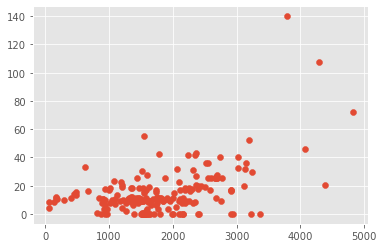

In [44]:
plt.scatter(runs['moving_time'],runs['elev'])
plt.show()

<AxesSubplot:xlabel='weekday'>

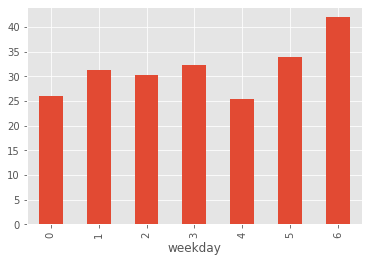

In [45]:
runs.groupby('weekday').mean()['moving_time_minutes'].plot.bar()

<AxesSubplot:xlabel='weekday'>

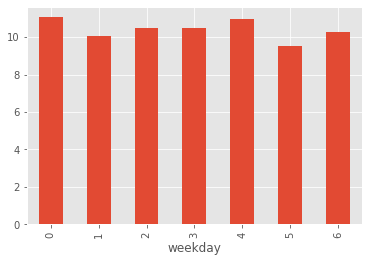

In [46]:
runs.groupby('weekday').mean()['avg_speed_kmh'].plot.bar()

<AxesSubplot:xlabel='weekday'>

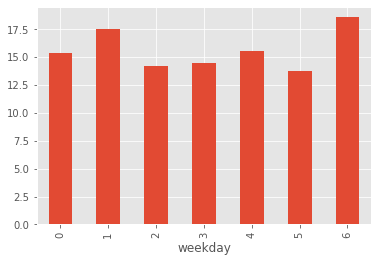

In [47]:
runs.groupby('weekday').mean()['max_speed_kmh'].plot.bar()

<AxesSubplot:xlabel='weekday'>

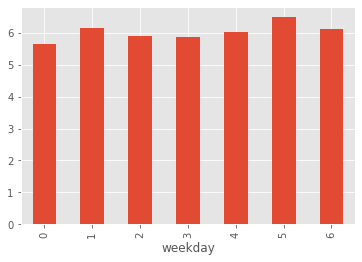

In [48]:
runs.groupby('weekday').mean()['pace'].plot.bar()

Text(0.5, 1.0, 'All Time vs Elevation')

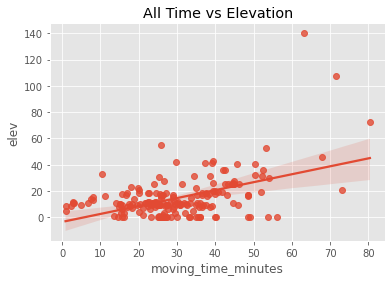

In [49]:
sns.regplot(x='moving_time_minutes', y = 'elev', data=runs).set_title("All Time vs Elevation")

In [50]:
runs[runs['avg_speed_kmh'] == runs['avg_speed_kmh'].max()]

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,kudos_count,comment_count,athlete_count,start_latlng,end_latlng,average_speed,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,elev_low,upload_id,external_id,pr_count,map.summary_polyline,weekday,start_time,location,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,pace_sub_5,year
159,319.1,54,58,7.6,Run,Run,5692067508,2021-07-26,Brasil,0,4,0,1,"[-22.06703, -50.298187]","[-22.06692, -50.29827]",5.909,8.9,86.6,156.5,176.0,601.2,592.6,6054785284.0,shealthd7bb339c-aa4d-488d-af5d-48449bcfb4e7.tcx,0,|}teCtz~qHXcBGCKUYOoAEy@OGFCtAN^fAXHLp@L,0,18:17:55,"Rua Oitil, Região Geográfica Intermediária d...",0.9,0.32,2.8125,21.33,32.04,8.6,True,2021


Text(0.5, 1.0, 'Average Speed vs Distance')

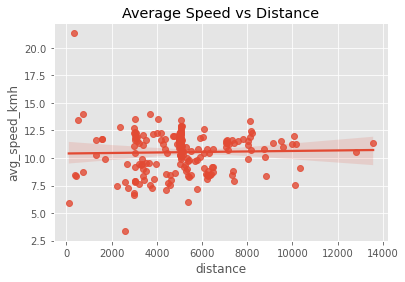

In [51]:
sns.regplot(x='distance', y = 'avg_speed_kmh', data=runs).set_title("Average Speed vs Distance")

In [52]:
runs[runs['max_speed_kmh'] == runs['max_speed_kmh'].max()]

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,kudos_count,comment_count,athlete_count,start_latlng,end_latlng,average_speed,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,elev_low,upload_id,external_id,pr_count,map.summary_polyline,weekday,start_time,location,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,pace_sub_5,year
156,3045.9,1054,1054,75.6,Run,Run,5666396963,2021-07-21,Brasil,1,7,0,5,"[-22.073385, -50.307487]","[-22.073723, -50.307312]",2.89,10.8,82.7,168.3,187.0,605.8,595.6,6027952048.0,shealth201fe450-a46a-405f-b344-dd818e439b61.tcx,0,teveCxt`rHb@fAHFn@c@BIAS[i@_B_EKK_@?e@P?JZr@\j...,2,19:10:34,"Rua Mario Nery de Souza Campos, Região Imedi...",17.57,3.05,5.760656,10.42,38.88,10.2,False,2021


Text(0.5, 1.0, 'Max Speed vs Distance')

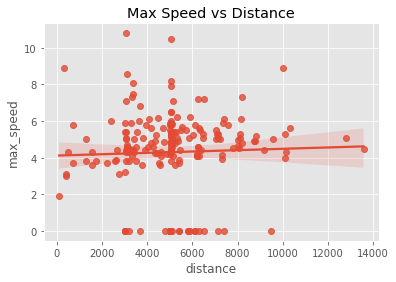

In [53]:
sns.regplot(x='distance', y = 'max_speed', data=runs).set_title("Max Speed vs Distance")

In [54]:
runs[runs['pace'] == runs['pace'].min()]

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,kudos_count,comment_count,athlete_count,start_latlng,end_latlng,average_speed,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,elev_low,upload_id,external_id,pr_count,map.summary_polyline,weekday,start_time,location,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,pace_sub_5,year
159,319.1,54,58,7.6,Run,Run,5692067508,2021-07-26,Brasil,0,4,0,1,"[-22.06703, -50.298187]","[-22.06692, -50.29827]",5.909,8.9,86.6,156.5,176.0,601.2,592.6,6054785284.0,shealthd7bb339c-aa4d-488d-af5d-48449bcfb4e7.tcx,0,|}teCtz~qHXcBGCKUYOoAEy@OGFCtAN^fAXHLp@L,0,18:17:55,"Rua Oitil, Região Geográfica Intermediária d...",0.9,0.32,2.8125,21.33,32.04,8.6,True,2021


Text(0.5, 1.0, 'Moving Time vs Pace')

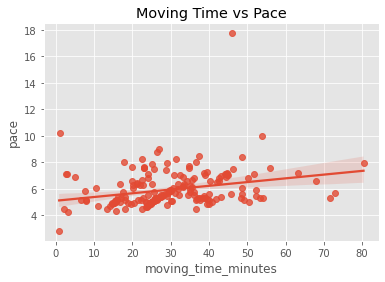

In [55]:
sns.regplot(x='moving_time_minutes', y = 'pace', data=runs).set_title("Moving Time vs Pace")

Text(0.5, 1.0, 'Distance vs Pace')

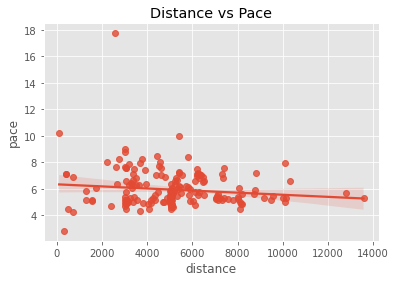

In [56]:
sns.regplot(x='distance', y = 'pace', data=runs).set_title("Distance vs Pace")

In [57]:
runs[runs['average_heartrate'] == runs['average_heartrate'].max()]

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,kudos_count,comment_count,athlete_count,start_latlng,end_latlng,average_speed,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,elev_low,upload_id,external_id,pr_count,map.summary_polyline,weekday,start_time,location,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,pace_sub_5,year
246,1724.3,625,1985,38.7,Run,Run,7478821502,2022-07-16,Brasil,0,3,0,26,"[-21.930779, -50.734997]","[-21.923746, -50.732327]",2.759,3.815,80.9,183.0,183.0,463.3,430.0,7972460128.0,shealthdd06d734-16c9-4a5f-a978-10f45d46b203.tcx,0,jjzdCvdttHVJlAR|@XhA`@pAVr@XxA^PHj@H`@Lh@HLHb@...,5,09:00:29,"Bastos, São Paulo",10.42,1.72,6.05814,9.9,13.73,33.3,False,2022


Text(0.5, 1.0, 'Moving Time vs Avg. Heart Rate')

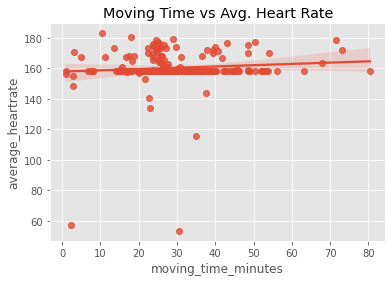

In [58]:
sns.regplot(x='moving_time_minutes', y='average_heartrate', data=runs).set_title("Moving Time vs Avg. Heart Rate")

Text(0.5, 1.0, 'Moving Time vs Avg. Heart Rate')

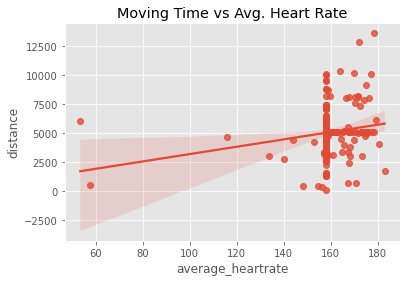

In [62]:
sns.regplot(x='average_heartrate', y='distance', data=runs).set_title("Moving Time vs Avg. Heart Rate")

In [59]:
runs[runs['max_heartrate'] == runs['max_heartrate'].max()]

,distance,moving_time,elapsed_time,total_elevation_gain,type,sport_type,id,start_date,location_country,achievement_count,kudos_count,comment_count,athlete_count,start_latlng,end_latlng,average_speed,max_speed,average_cadence,average_heartrate,max_heartrate,elev_high,elev_low,upload_id,external_id,pr_count,map.summary_polyline,weekday,start_time,location,moving_time_minutes,distance_km,pace,avg_speed_kmh,max_speed_kmh,elev,pace_sub_5,year
251,5040.5,1467,1467,21.1,Run,Run,7683587125,2022-08-22,Brasil,2,8,0,1,"[-22.10379, -50.17853]","[-22.105629, -50.17524]",3.436,4.738,86.3,178.6,206.0,604.2,593.6,8200457942.0,shealthb8915e5c-d94b-4839-a2ca-17c0427d799a.tcx,0,tc|eCxngqHbAeBb@cAXi@t@gBp@qAn@}AZk@\y@\m@dA{B...,0,18:15:53,"Pompeia, São Paulo",24.45,5.04,4.85119,12.37,17.06,10.6,True,2022


Text(0.5, 1.0, 'Moving Time vs Max. Heart Rate')

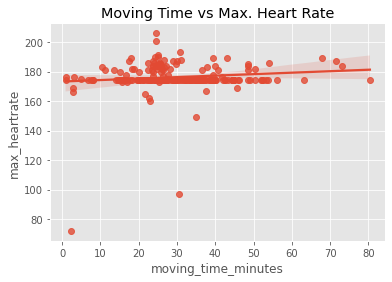

In [60]:
sns.regplot(x='moving_time_minutes', y='max_heartrate', data=runs).set_title("Moving Time vs Max. Heart Rate")

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_8232/3097083979.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


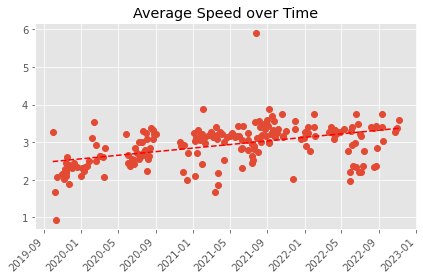

In [63]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.asarray(runs.start_date)
y = np.asarray(runs.average_speed)

ax1.plot_date(x, y)
ax1.set_title('Average Speed over Time')

#add trend line
x2 = mdates.date2num(x)

z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')

fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()

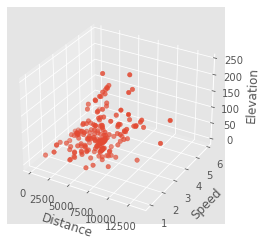

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = runs['distance']
y = runs['average_speed']
z = runs['total_elevation_gain']

ax.set_xlabel("Distance")
ax.set_ylabel("Speed")
ax.set_zlabel("Elevation")

ax.scatter(x, y, z)

plt.show()

In [65]:
startdate = pd.to_datetime("2021-01-01").date()
recently_runs = runs.loc[runs['start_date'] > startdate]

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_8232/2438023629.py:19: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


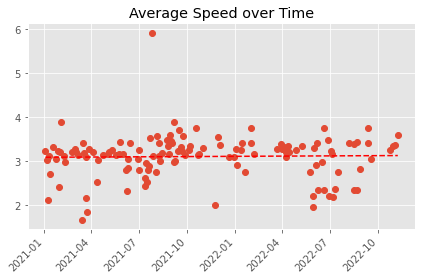

In [66]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

x = np.asarray(recently_runs.start_date)
y = np.asarray(recently_runs.average_speed)

ax1.plot_date(x, y)
ax1.set_title('Average Speed over Time')

#add trend line
x1 = mdates.date2num(x)

z=np.polyfit(x1,y,1)
p=np.poly1d(z)
plt.plot(x,p(x1),'r--')

fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()

/var/folders/xc/brt57cys157_3fpw5lmlrpkc0000gn/T/ipykernel_8232/2503613642.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


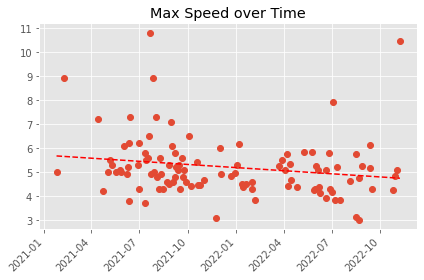

In [67]:
#max speed over time
fig = plt.figure()
ax2 = fig.add_subplot(111)

recently_runs = recently_runs.drop(recently_runs[recently_runs.max_speed == 0].index)


x = np.asarray(recently_runs.start_date)
y = np.asarray(recently_runs.max_speed)

ax2.plot_date(x, y)
ax2.set_title('Max Speed over Time')

#add trend line
x2 = mdates.date2num(x)

z=np.polyfit(x2,y,1)
p=np.poly1d(z)
plt.plot(x,p(x2),'r--')

fig.autofmt_xdate(rotation=45)
fig.tight_layout()
fig.show()

## Feature Selection
https://paulovasconcellos.com.br/como-selecionar-as-melhores-features-para-seu-modelo-de-machine-learning-2e9df83d062a

## Machine Learning 

In [ ]:
corr = runs.corr()
plt.figure(figsize = (12,8))
sns.heatmap(corr, fmt=".2f");

In [ ]:
categorical_cols = [col for col in runs.columns if runs[col].dtypes == 'O']
categorical_cols

In [ ]:
runs = runs.sample(frac=1).reset_index(drop=True)

In [ ]:
X = runs.drop(categorical_cols, axis=1)
X_columns = X.columns
X = StandardScaler().fit_transform(X)
X

### Clustering

In [ ]:
model = KMeans(n_clusters=4)
model.fit(X)
runs['Cluster'] = model.labels_

In [ ]:
runs['Cluster'].value_counts()

In [ ]:
runs.groupby('Cluster').mean()

In [ ]:
runs.groupby('Cluster').std()

In [ ]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
runs[runs['Cluster'] == 2]

### Regression

In [ ]:
y = runs['pace']
X = runs.drop('pace',1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
regressor = autosklearn.regression.AutoSklearnClassifier(time_left_for_this_task=60*15)
regressor.fit(X_train, y_train)

In [ ]:
print(regressor.sprint_statistics())

In [ ]:
print(regressor.show_models())

In [ ]:
predictions = regressor.predict(X_test)
predictions